# KAYAK PROJECT : Part 3 ETL PROCESS

## I. Extract from S3 bucket

In [1]:
import boto3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sqlite3

In [2]:
# Initialize a session using your AWS credentials
session = boto3.Session(
    aws_access_key_id="AWS_ACCESS_KEY",
    aws_secret_access_key="AWS_SECRET_ACCESS_KEY",
)

s3 = session.client('s3')

In [3]:
# Specify the object key (filename) to download
key_1 = 'all_cities_info_deals.csv'
key_2 = 'results_link_df.csv'
key_3 = 'coordinates_df.csv'
key_4 = 'forecast_weather_5daysdf.csv'
# Specify the local file path to save the downloaded object
local_file_path = f'./extracted_data_from_S3/{key_1}'
local_file_path_2 = f'./extracted_data_from_S3/{key_2}'
local_file_path_3 = f'./extracted_data_from_S3/{key_3}'
local_file_path_4 = f'./extracted_data_from_S3/{key_4}'

bucket_name="holiday-recommendation"
# Download the object
s3.download_file(bucket_name, key_1, local_file_path)
s3.download_file(bucket_name, key_2, local_file_path_2)
s3.download_file(bucket_name, key_3, local_file_path_3)
s3.download_file(bucket_name, key_4, local_file_path_4)

print(f"Downloaded {key_1} from {bucket_name} to {local_file_path}")

Downloaded all_cities_info_deals.csv from holiday-recommendation to ./extracted_data/all_cities_info_deals.csv


## II. Transform

#### a. Transform Scraped data from booking using Beautiful Soup and Selenium

In [4]:
all_cities_info_deals_df=pd.read_csv('./extracted_data/all_cities_info_deals.csv')
all_cities_info_deals_df.head()

,city,name,hotel_prices,rating,number of review,hotel_link
0,Amiens,Appart'City Confort Amiens Gare,$930,Scored 7.6,"1,743 reviews",https://www.booking.com/hotel/fr/appart-city-a...
1,Amiens,The Nest,$973,Scored 8.2,137 reviews,https://www.booking.com/hotel/fr/the-nest-amie...
2,Amiens,Nemea Appart Hotel Coliseum Amiens Centre,"$1,029",Scored 8.6,332 reviews,https://www.booking.com/hotel/fr/nemea-appart-...
3,Amiens,Odalys City Amiens Blamont,"$1,074",Scored 8.0,"1,817 reviews",https://www.booking.com/hotel/fr/appart-39-oda...
4,Amiens,Le Saint Louis,"$1,078",Scored 8.1,"1,336 reviews",https://www.booking.com/hotel/fr/le-saint-loui...


In [5]:
all_cities_info_deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   city              694 non-null    object
 1   name              694 non-null    object
 2   hotel_prices      694 non-null    object
 3   rating            694 non-null    object
 4   number of review  694 non-null    object
 5   hotel_link        694 non-null    object
dtypes: object(6)
memory usage: 32.7+ KB


In [6]:
# Cleaning prices column
all_cities_info_deals_df['hotel_prices'] = all_cities_info_deals_df['hotel_prices'].astype('string')
all_cities_info_deals_df['hotel_prices'] = all_cities_info_deals_df['hotel_prices'].str.replace('$', '')
all_cities_info_deals_df['hotel_prices'] = all_cities_info_deals_df['hotel_prices'].str.replace(',', '')
all_cities_info_deals_df['hotel_prices'] = all_cities_info_deals_df['hotel_prices'].astype(float)


In [7]:
# Cleaning rating column
all_cities_info_deals_df['rating'] = all_cities_info_deals_df['rating'].astype(str)
all_cities_info_deals_df['rating'] = all_cities_info_deals_df['rating'].str.replace('Scored', '')
all_cities_info_deals_df['rating'] = all_cities_info_deals_df['rating'].replace('No rating', np.nan)
all_cities_info_deals_df['rating'] = all_cities_info_deals_df['rating'].str.strip()
all_cities_info_deals_df['rating'] = pd.to_numeric(all_cities_info_deals_df['rating'], errors='coerce')

In [8]:
# Cleaning review column
all_cities_info_deals_df['number of review'] = all_cities_info_deals_df['number of review'].astype(str)
all_cities_info_deals_df['number of review'] = all_cities_info_deals_df['number of review'].str.replace('reviews','')
all_cities_info_deals_df['number of review'] = all_cities_info_deals_df['number of review'].str.replace(',', '')
all_cities_info_deals_df['number of review'] = all_cities_info_deals_df['number of review'].replace('No ', np.nan)
all_cities_info_deals_df['number of review'] = all_cities_info_deals_df['number of review'].astype(float)



In [9]:
all_cities_info_deals_df['city'] = all_cities_info_deals_df['city'].astype('string')
all_cities_info_deals_df['name'] = all_cities_info_deals_df['name'].astype('string')
all_cities_info_deals_df['hotel_link'] = all_cities_info_deals_df['hotel_link'].astype('string')
all_cities_info_deals_df.rename(columns={'name':'hotel_name'}, inplace=True)

In [10]:
all_cities_info_deals_df.head()

,city,hotel_name,hotel_prices,rating,number of review,hotel_link
0,Amiens,Appart'City Confort Amiens Gare,930.0,7.6,1743.0,https://www.booking.com/hotel/fr/appart-city-a...
1,Amiens,The Nest,973.0,8.2,137.0,https://www.booking.com/hotel/fr/the-nest-amie...
2,Amiens,Nemea Appart Hotel Coliseum Amiens Centre,1029.0,8.6,332.0,https://www.booking.com/hotel/fr/nemea-appart-...
3,Amiens,Odalys City Amiens Blamont,1074.0,8.0,1817.0,https://www.booking.com/hotel/fr/appart-39-oda...
4,Amiens,Le Saint Louis,1078.0,8.1,1336.0,https://www.booking.com/hotel/fr/le-saint-loui...


In [11]:
all_cities_info_deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              694 non-null    string 
 1   hotel_name        694 non-null    string 
 2   hotel_prices      694 non-null    float64
 3   rating            687 non-null    float64
 4   number of review  687 non-null    float64
 5   hotel_link        694 non-null    string 
dtypes: float64(3), string(3)
memory usage: 32.7 KB


In [12]:
results_link_df=pd.read_csv('./extracted_data/results_link_df.csv')
results_link_df.head()

,Unnamed: 0,hotel_name,hotel_address,latitude,longitude
0,0,Appart'City Confort Amiens Gare,"80, boulevard d'Alsace-Lorraine, 80000 Amiens,...",49.894316,2.309761
1,1,The Nest,"37 Boulevard Maignan Larivière, 80000 Amiens, ...",49.889307,2.294634
2,2,Nemea Appart Hotel Coliseum Amiens Centre,"25 Rue Frédéric Petit, 80000 Amiens, France",49.892175,2.288935
3,3,Odalys City Amiens Blamont,"25 rue du Blamont, 80000 Amiens, France",49.887148,2.311611
4,4,Le Saint Louis,"24 Rue Des Otages, 80000 Amiens, France",49.889779,2.302499


In [13]:
results_link_df.drop(columns=['Unnamed: 0'],inplace=True)

In [14]:
results_link_df['hotel_name']=results_link_df['hotel_name'].astype('string')
results_link_df['hotel_address']=results_link_df['hotel_address'].astype('string')

In [15]:
#Merge all_cities_info_deals_df and results_link_df to have the hotels deal, address and coordinates in the same dataframe
hotel_deal_merged_final = pd.merge(all_cities_info_deals_df, results_link_df, on='hotel_name', how='left')
hotel_deal_merged_final.head()

,city,hotel_name,hotel_prices,rating,number of review,hotel_link,hotel_address,latitude,longitude
0,Amiens,Appart'City Confort Amiens Gare,930.0,7.6,1743.0,https://www.booking.com/hotel/fr/appart-city-a...,"80, boulevard d'Alsace-Lorraine, 80000 Amiens,...",49.894316,2.309761
1,Amiens,The Nest,973.0,8.2,137.0,https://www.booking.com/hotel/fr/the-nest-amie...,"37 Boulevard Maignan Larivière, 80000 Amiens, ...",49.889307,2.294634
2,Amiens,Nemea Appart Hotel Coliseum Amiens Centre,1029.0,8.6,332.0,https://www.booking.com/hotel/fr/nemea-appart-...,"25 Rue Frédéric Petit, 80000 Amiens, France",49.892175,2.288935
3,Amiens,Odalys City Amiens Blamont,1074.0,8.0,1817.0,https://www.booking.com/hotel/fr/appart-39-oda...,"25 rue du Blamont, 80000 Amiens, France",49.887148,2.311611
4,Amiens,Le Saint Louis,1078.0,8.1,1336.0,https://www.booking.com/hotel/fr/le-saint-loui...,"24 Rue Des Otages, 80000 Amiens, France",49.889779,2.302499


In [16]:
hotel_deal_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              740 non-null    string 
 1   hotel_name        740 non-null    string 
 2   hotel_prices      740 non-null    float64
 3   rating            733 non-null    float64
 4   number of review  733 non-null    float64
 5   hotel_link        740 non-null    string 
 6   hotel_address     687 non-null    string 
 7   latitude          687 non-null    float64
 8   longitude         687 non-null    float64
dtypes: float64(5), string(4)
memory usage: 52.2 KB


#### b. Transform data from APIs

In [17]:
coordinates_df=pd.read_csv('./extracted_data/coordinates_df.csv')
coordinates_df['city']=coordinates_df['city'].astype('string')
coordinates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city       34 non-null     string 
 1   latitude   34 non-null     float64
 2   longitude  34 non-null     float64
dtypes: float64(2), string(1)
memory usage: 948.0 bytes


In [18]:
forecast_weather_5days_df=pd.read_csv('./extracted_data/forecast_weather_5daysdf.csv')
forecast_weather_5days_df['city']=forecast_weather_5days_df['city'].astype('string')
forecast_weather_5days_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          1360 non-null   string 
 1   latitude      1360 non-null   float64
 2   longitude     1360 non-null   float64
 3   timepoint     1360 non-null   int64  
 4   main_weather  1360 non-null   object 
 5   feels_like    1360 non-null   float64
 6   humidity      1360 non-null   int64  
 7   wind_speed    1360 non-null   float64
 8   city_id       1360 non-null   int64  
dtypes: float64(4), int64(3), object(1), string(1)
memory usage: 95.8+ KB


In [19]:
# Select numerical columns for calculation TRANSFORM
numerical_columns = forecast_weather_5days_df.select_dtypes(include=(float, int)).columns

# Calculate average numerical values by city
avg_numerical = forecast_weather_5days_df.groupby('city')[numerical_columns].mean()

# Calculate mode of 'main_weather' by city
avg_categorical = forecast_weather_5days_df.groupby('city')['main_weather'].agg(lambda x: x.mode().iloc[0])

# Create DataFrame for categorical data
avg_categorical_df = pd.DataFrame(avg_categorical, columns=["main_weather"])

# Join the DataFrames on the 'city' column
avg_forecast_weather_34cities_5days_df = avg_numerical.join(avg_categorical_df)

# Print the resulting DataFrame
print(avg_forecast_weather_34cities_5days_df.head())

                  latitude  longitude     timepoint  feels_like  humidity  \
city                                                                        
Aigues Mortes    43.565823   4.191284  1.719646e+09    23.10575    73.100   
Aix en Provence  43.529842   5.447474  1.719646e+09    26.01450    53.200   
Amiens           49.894171   2.295695  1.719646e+09    16.95475    75.400   
Annecy           45.899235   6.128885  1.719646e+09    22.61425    77.825   
Ariège           42.845802   1.606759  1.719646e+09    22.70450    78.900   

                 wind_speed  city_id     main_weather  
city                                                   
Aigues Mortes       3.23625      1.0        clear sky  
Aix en Provence     3.29375      2.0        clear sky  
Amiens              3.77450      3.0  overcast clouds  
Annecy              1.47300      4.0       light rain  
Ariège              1.89475      5.0       light rain  


In [20]:
# Transform the categorical variable main_weather into numerical

# We assign each value to a number (in a logical order)
main_weather_importance = {'clear sky': 5, 'few clouds': 4, 'scattered clouds': 3, 'broken clouds': 2, 'light rain': 1}

# Creation of an additionnal column to enter those scores
avg_forecast_weather_34cities_5days_df['main_weather_scores'] = avg_forecast_weather_34cities_5days_df['main_weather'].map(main_weather_importance)

# Conversion of this column into numerical
avg_forecast_weather_34cities_5days_df['main_weather_scores'] = pd.to_numeric(avg_forecast_weather_34cities_5days_df['main_weather_scores'], errors='coerce')

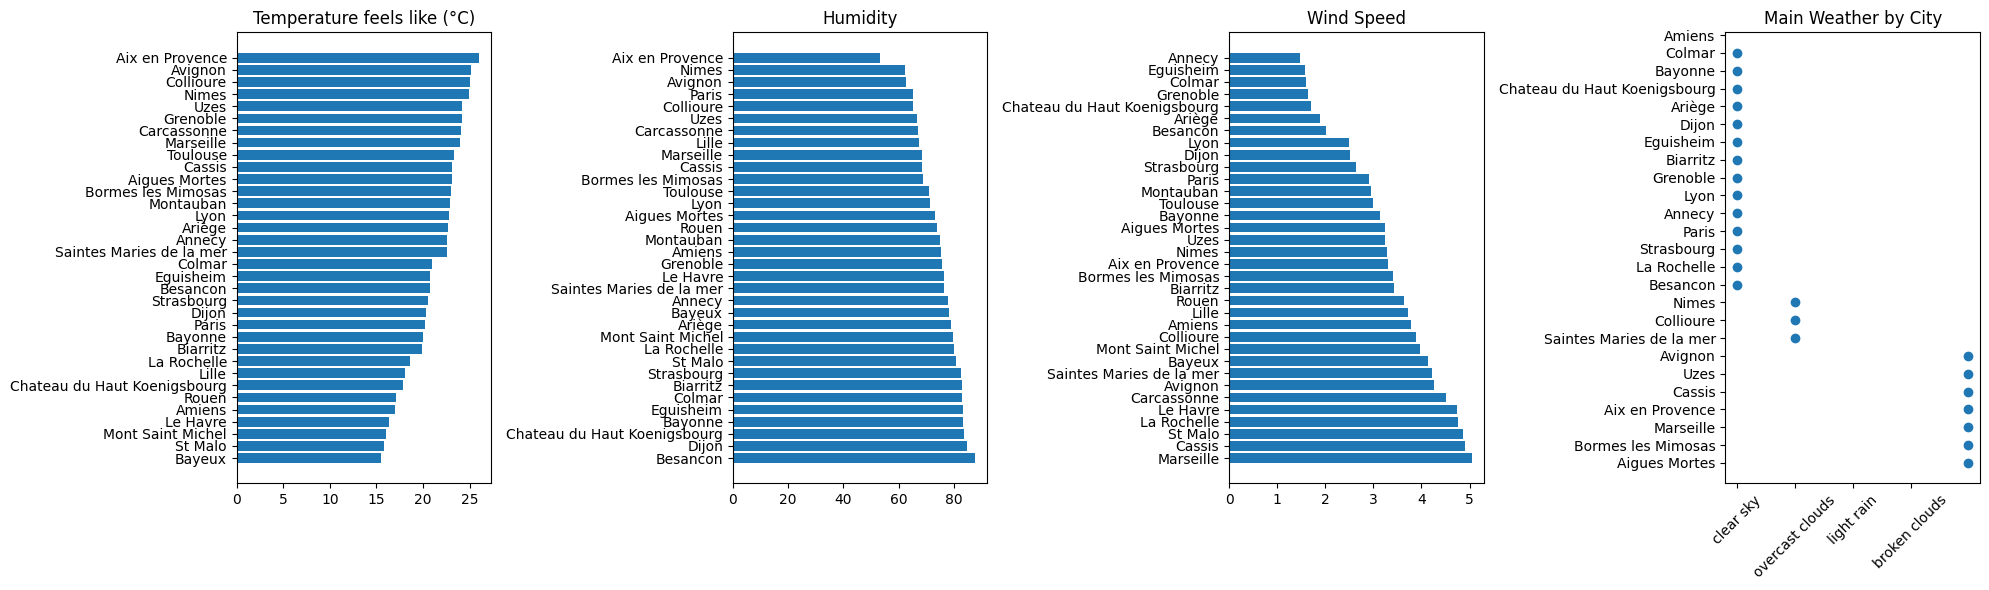

In [21]:
# Creation of one dataframe by variable (sorted)
top_temperature = avg_forecast_weather_34cities_5days_df.sort_values(by='feels_like', ascending=True)['feels_like']
top_humidity = avg_forecast_weather_34cities_5days_df.sort_values(by='humidity', ascending=False)['humidity']
top_wind = avg_forecast_weather_34cities_5days_df.sort_values(by='wind_speed', ascending=False)['wind_speed']
top_main_weather = avg_forecast_weather_34cities_5days_df.sort_values(by='main_weather_scores', ascending=False)['main_weather_scores']

# Figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Subplot 1: Temperature
axs[0].barh(top_temperature.index, top_temperature)
axs[0].set_title('Temperature feels like (°C)')

# Subplot 2: Humidity
axs[1].barh(top_humidity.index, top_humidity)
axs[1].set_title('Humidity')

# Subplot 3: Wind Speed
axs[2].barh(top_wind.index, top_wind)
axs[2].set_title('Wind Speed')

# # Subplot 4: Main Weather
unique_main_weather = avg_forecast_weather_34cities_5days_df['main_weather'].unique()
axs[3].scatter(top_main_weather, top_main_weather.index)
axs[3].set_xticks(range(1, len(unique_main_weather) + 1))
axs[3].set_xticklabels(unique_main_weather, rotation=45)
axs[3].set_title('Main Weather by City')

plt.tight_layout()
plt.show()


In [31]:
weights = {
    'wind_speed': 5,
    'main_weather_scores': 10,
    'humidity': 2,
    'feels_like': 10
}


# We calculate a score for each city
avg_forecast_weather_34cities_5days_df['final_score'] = round(
    avg_forecast_weather_34cities_5days_df['wind_speed'] * weights['wind_speed'] +
    avg_forecast_weather_34cities_5days_df['main_weather_scores'] * weights['main_weather_scores'] +
    avg_forecast_weather_34cities_5days_df['humidity'] * weights['humidity'] +
    avg_forecast_weather_34cities_5days_df['feels_like'] * weights['feels_like']
)

avg_forecast_weather_34cities_5days_df.reset_index(inplace=True)

In [32]:
avg_forecast_weather_34cities_5days_df.head()

,city,latitude,longitude,timepoint,feels_like,humidity,wind_speed,city_id,main_weather,main_weather_scores,final_score
0,Aigues Mortes,43.565823,4.191284,1.719646e+09,23.10575,73.100,3.23625,1.0,clear sky,5.0,443.0
1,Aix en Provence,43.529842,5.447474,1.719646e+09,26.01450,53.200,3.29375,2.0,clear sky,5.0,433.0
2,Amiens,49.894171,2.295695,1.719646e+09,16.95475,75.400,3.77450,3.0,overcast clouds,NaN,NaN
3,Annecy,45.899235,6.128885,1.719646e+09,22.61425,77.825,1.47300,4.0,light rain,1.0,399.0
4,Ariège,42.845802,1.606759,1.719646e+09,22.70450,78.900,1.89475,5.0,light rain,1.0,404.0


In [33]:
avg_forecast_weather_34cities_5days_df.columns

Index(['city', 'latitude', 'longitude', 'timepoint', 'feels_like', 'humidity',
       'wind_speed', 'city_id', 'main_weather', 'main_weather_scores',
       'final_score'],
      dtype='object')

In [34]:
hotel_deal_merged_final.head()

,city,hotel_name,hotel_prices,rating,number of review,hotel_link,hotel_address,latitude,longitude
0,Amiens,Appart'City Confort Amiens Gare,930.0,7.6,1743.0,https://www.booking.com/hotel/fr/appart-city-a...,"80, boulevard d'Alsace-Lorraine, 80000 Amiens,...",49.894316,2.309761
1,Amiens,The Nest,973.0,8.2,137.0,https://www.booking.com/hotel/fr/the-nest-amie...,"37 Boulevard Maignan Larivière, 80000 Amiens, ...",49.889307,2.294634
2,Amiens,Nemea Appart Hotel Coliseum Amiens Centre,1029.0,8.6,332.0,https://www.booking.com/hotel/fr/nemea-appart-...,"25 Rue Frédéric Petit, 80000 Amiens, France",49.892175,2.288935
3,Amiens,Odalys City Amiens Blamont,1074.0,8.0,1817.0,https://www.booking.com/hotel/fr/appart-39-oda...,"25 rue du Blamont, 80000 Amiens, France",49.887148,2.311611
4,Amiens,Le Saint Louis,1078.0,8.1,1336.0,https://www.booking.com/hotel/fr/le-saint-loui...,"24 Rue Des Otages, 80000 Amiens, France",49.889779,2.302499


In [35]:
hotel_deal_merged_final.columns

Index(['city', 'hotel_name', 'hotel_prices', 'rating', 'number of review',
       'hotel_link', 'hotel_address', 'latitude', 'longitude'],
      dtype='object')

In [36]:
print(len(avg_forecast_weather_34cities_5days_df))

34


#### III. Load the data into Sqlite database

In [37]:
import sqlite3

# Connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('weather_data.db')

# Create a cursor object
cursor = conn.cursor()

# Define your table creation SQL
create_table_sql = '''
CREATE TABLE IF NOT EXISTS weather_data (
    city TEXT,
    latitude REAL,
    longitude REAL,
    timepoint TEXT,
    feels_like REAL,
    humidity INTEGER,
    wind_speed REAL,
    city_id INTEGER,
    main_weather TEXT,
    main_weather_scores REAL,
    final_score REAL
);
'''

# Execute the SQL to create the table
cursor.execute(create_table_sql)

# Commit the changes and close the connection
conn.commit()
conn.close()

print("SQLite database and table created successfully.")


SQLite database and table created successfully.


In [38]:
# Connect to the SQLite database
conn = sqlite3.connect('weather_data.db')

# Insert DataFrame records into the SQLite table
avg_forecast_weather_34cities_5days_df.to_sql('weather_data', conn, if_exists='replace', index=False)

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Data inserted into SQLite table successfully.")


Data inserted into SQLite table successfully.


In [48]:
# Connect to the SQLite database
conn = sqlite3.connect('weather_data.db')

# Create a cursor object
cursor = conn.cursor()

# SQL query to select top 5 cities by final_score in descending order
query = '''
SELECT *
FROM weather_data
ORDER BY final_score DESC
LIMIT 5
'''

# Execute the query
cursor.execute(query)

# Fetch all rows from the executed query
top_5_cities_df = pd.read_sql(query, conn)


# Close the connection
conn.close()


In [49]:

fig = px.scatter_mapbox(
    top_5_cities_df,
    title="Top 5 cities for our holidays",
    lat="latitude",
    lon="longitude",
    color="wind_speed",
    size="feels_like",
    zoom=5,
    mapbox_style="open-street-map",
    hover_name=top_5_cities_df['city'],
    hover_data = ['wind_speed', 'main_weather','feels_like','humidity'],
)

fig.show()

##### According to the criteria we define, we have our top 5 cities to plan our trip. However we still need to find the best hotel deals

In [53]:
# Connect to the database (or create it if it doesn't exist)
conn = sqlite3.connect('best_hotels_deals.db')

# Create a cursor object
cursor = conn.cursor()

# Create a table
cursor.execute('''
CREATE TABLE IF NOT EXISTS all_cities_info_deals (
    city TEXT,
    hotel_name TEXT,
    hotel_prices INTEGER,
    rating REAL,
    number_of_review INTEGER,
    hotel_link TEXT,
    hotel_address TEXT,
    latitude REAL,
    longitude REAL
)
''')

# Commit the changes and close the connection
conn.commit()
conn.close()


In [54]:
top_5_cities_df['city']

0        Marseille
1          Avignon
2    Aigues Mortes
3           Cassis
4             Uzes
Name: city, dtype: object

In [56]:
hotel_deal_merged_final.columns

Index(['city', 'hotel_name', 'hotel_prices', 'rating', 'number of review',
       'hotel_link', 'hotel_address', 'latitude', 'longitude'],
      dtype='object')

In [65]:
# Connect to the SQLite database
conn = sqlite3.connect('best_hotels_deals.db')

# Write the SQL query
query = '''
SELECT city, hotel_name, hotel_prices, rating, hotel_link, hotel_address, latitude, longitude
FROM hotel_deal_merged_final
WHERE city = 'Marseille'
ORDER BY hotel_prices ASC
LIMIT 1
'''

# Execute the query and fetch the result into a DataFrame
cheapest_hotel_marseille_df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Display the result
cheapest_hotel_marseille_df


,city,hotel_name,hotel_prices,rating,hotel_link,hotel_address,latitude,longitude
0,Marseille,Appart'City Confort Marseille Centre Prado Vél...,1271.0,7.7,https://www.booking.com/hotel/fr/seven-urban-s...,"1 Rue Vandel, 13008 Marseille, France",43.279855,5.390496


In [71]:
# Connect to the SQLite database
conn = sqlite3.connect('best_hotels_deals.db')

# Write the SQL query
query = '''
SELECT city, hotel_name, hotel_prices, rating, hotel_link, hotel_address, latitude, longitude
FROM hotel_deal_merged_final
WHERE city = 'Avignon'
ORDER BY hotel_prices ASC
LIMIT 1
'''

# Execute the query and fetch the result into a DataFrame
cheapest_hotel_avignon_df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Display the result for 7 night 3 pers
cheapest_hotel_avignon_df


,city,hotel_name,hotel_prices,rating,hotel_link,hotel_address,latitude,longitude
0,Avignon,Hôtel Kyriad Cap Sud,793.0,7.7,https://www.booking.com/hotel/fr/kyriad-avigno...,"35 Allee Des Fenaisons, 84000 Avignon, France",43.927448,4.847889


In [74]:
top_5_cities_df['city']

0        Marseille
1          Avignon
2    Aigues Mortes
3           Cassis
4             Uzes
Name: city, dtype: object

In [77]:
# List of cities to query
cities = ['Marseille', 'Cassis', 'Avignon', 'Aigues-Mortes', 'Uzès']

# Function to get the cheapest hotel deal for a given city
def get_cheapest_hotel(city):
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect('best_hotels_deals.db')
        
        # Write the SQL query
        query = f'''
        SELECT city, hotel_name, hotel_prices,rating, hotel_link, hotel_address, latitude, longitude
        FROM hotel_deal_merged_final
        WHERE city = '{city}'
        ORDER BY hotel_prices ASC
        LIMIT 1
        '''
        
        # Execute the query and fetch the result into a DataFrame
        df = pd.read_sql(query, conn)
        
        # Close the connection
        conn.close()
        
        return df
    
    except Exception as e:
        print(f"An error occurred for city '{city}': {e}")
        return pd.DataFrame()

# Fetch the cheapest hotel deal for each city
results = []
for city in cities:
    df = get_cheapest_hotel(city)
    if not df.empty:
        results.append(df)
    else:
        print(f"No data found for city '{city}'")

# Combine results into a single DataFrame
combined_results_df = pd.concat(results, ignore_index=True)

# Display the result for 7 night 3 pers
combined_results_df


,city,hotel_name,hotel_prices,rating,hotel_link,hotel_address,latitude,longitude
0,Marseille,Appart'City Confort Marseille Centre Prado Vél...,1271.0,7.7,https://www.booking.com/hotel/fr/seven-urban-s...,"1 Rue Vandel, 13008 Marseille, France",43.279855,5.390496
1,Cassis,Logis Noemys pont de l'Etoile - ex Mas de L'Et...,995.0,7.7,https://www.booking.com/hotel/fr/le-mas-de-let...,"Chemin de la Gauthière, 13400 Aubagne, France",43.323016,5.594385
2,Avignon,Hôtel Kyriad Cap Sud,793.0,7.7,https://www.booking.com/hotel/fr/kyriad-avigno...,"35 Allee Des Fenaisons, 84000 Avignon, France",43.927448,4.847889
3,Aigues-Mortes,Residence Residéal La Grande Motte,868.0,7.3,https://www.booking.com/hotel/fr/residence-res...,"312 Allée de La Plage, 34280 La Grande-Motte, ...",43.557926,4.097654
4,Uzès,greet hôtel Pont du Gard - Route d'Avignon,777.0,8.4,https://www.booking.com/hotel/fr/la-fenouiller...,"247 Chemin de la Fenouillère, 30390 Estézargue...",43.951664,4.638676


In [80]:
fig = px.scatter_mapbox(combined_results_df,
                        lat="latitude",
                        lon="longitude",
                        hover_name="hotel_name",
                        hover_data={"city": True, "hotel_prices": True, "rating": True, "hotel_link": True},
                        color="hotel_prices",
                        size="hotel_prices",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15,
                        zoom=5,
                        title="Top Hotel Deals")

# Update the layout for mapbox style
fig.update_layout(mapbox_style="open-street-map")

# Display the map
fig.show()